<a href="https://colab.research.google.com/github/pebut/Hakaton/blob/main/PandemicHakaton_track3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np #Библиотека работы с массивами
import pandas as pd # Библиотека для работы с базами
import math

from tensorflow.keras.models import Sequential, Model # 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten #
from tensorflow.keras import utils #Используем для to_categoricall
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop #
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence #
from tensorflow.keras.preprocessing.sequence import pad_sequences #
from tensorflow.keras.callbacks import LambdaCallback # подключаем колбэки

from sklearn.preprocessing import StandardScaler # 
from sklearn.model_selection import train_test_split # Для разбивки на выборки
from sklearn.metrics import mean_squared_error, mean_absolute_error #
#from google.colab import files #Для загрузки своей картинки

import random #Для генерации случайных чисел 
import math # Для округления
#import os #Для работы с файлами 
import re #
import matplotlib.pyplot as plt #
%matplotlib inline

from IPython.display import clear_output


In [3]:
from google.colab import drive # Подключаем диск
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Осторожно! Запуск всех разделов сразу, может привести к недостатку памяти и сессия перезапустится.

##Загружаем базу и смотрим содержание



In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

fixed_df = pd.read_csv('/content/drive/MyDrive/Hakaton/train.csv', sep=';',encoding='utf8')



In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Hakaton/test.csv', sep=';',encoding='utf8')

In [3]:
gorod = pd.read_csv('/content/drive/MyDrive/Hakaton/spisok_gorodov.csv', sep=';',encoding='utf8')

In [4]:
gorod.head()

,No,City,Type
0,1,Адыгейск,Малый
1,2,Майкоп,Большой
2,3,Горно-Алтайск,Средний
3,4,Алейск,Малый
4,5,Барнаул,Крупнейший


In [4]:
f=open('/content/drive/MyDrive/Hakaton/unique_pos.txt')
s=(f.read())
pos=s.split(',')#вместо запятой может бить точка, любой символ
print(pos)   #(если у вас в файле дание через пробел топишем  пробел, через точку-точку)
f.close()

['инженер', 'монтажник', 'юрист', 'персональный менеджер', 'делопроизводитель', 'административная работа', 'начальник отдела охраны труда', 'hr менеджер', 'подсобный рабочий', 'юрист', 'помощник', 'секретарь', 'специалист', 'личный водитель', 'водитель . кат в.с.', 'руководитель отдела продаж', 'менеджер по закупкам', 'начальник отдела закупок', 'инспектор', 'бурильщик капитального ремонта скважин', 'продавец продовольственных товаров', 'главный/заместитель главного бухгалтера', 'психолог', 'архитектор индивидуальных жилых домов', 'менеджер', 'уборщик территории', 'военнослужащий', 'специалист', 'младший научный сотрудник', 'руководитель отдела', 'инженер-электрик', 'инженер по транспорту', 'няня', 'кассир-операционист в банк', 'парикмахер', 'менеджер по продажам', 'охранник', 'без разницы', 'продавец', 'продавец-кассир', 'воспитатель', 'водитель', 'слесарь-ремонтник', 'торговля', 'геолог', 'рассмотрю варианты', 'рабочий', 'мастер строительных и монтажных работ', 'артист драмы', 'консу

In [5]:
# Количество резюме и критерии
print(fixed_df.shape)

(306270, 25)


In [9]:
fixed_df.head(10)

,id,position,region,industry,locality,locality_name,education_type,drive_licences,citizenship,schedule,employement_type,age,gender,experience,salary_desired,relocation_ready,travel_ready,retraining_ready,is_worldskills_participant,has_qualifications,completeness_rate,creation_date,modification_date,publish_date,salary
0,0,Специалист,Тульская область,"Государственная служба, некоммерческие организ...",7100000100000,Тула,Незаконченное высшее,[B],Российская Федерация,Полный рабочий день,Полная занятость,21.0,Мужской,3,35000,False,False,True,NaN,NaN,64.0,2020-05-07,2020-05-08,2020-05-07,37500
1,1,Лаборант,Алтайский край,"Государственная служба, некоммерческие организ...",2200000100000,Барнаул,Высшее,[B],Российская Федерация,Полный рабочий день,Полная занятость,26.0,Женский,4,15000,False,True,True,NaN,NaN,88.0,2020-10-21,2020-10-27,2020-10-27,14000
2,3,"Специалист, администратор, бухгалтер, экономист",Ульяновская область,"Административная работа, секретариат, АХО",7300000200000,Димитровград,Высшее,[B],Российская Федерация,Полный рабочий день,Полная занятость,36.0,Женский,12,20000,False,NaN,True,NaN,NaN,78.0,2019-04-25,2020-02-04,2020-02-04,24600
3,4,Специалист,Свердловская область,"Государственная служба, некоммерческие организ...",6600002300000,Нижний Тагил,Высшее,[B],Российская Федерация,Полный рабочий день,Полная занятость,34.0,Женский,9,30000,False,False,False,NaN,NaN,91.0,2020-09-19,2020-09-20,2020-09-19,16075
4,5,Инструктор по плаванию,Иркутская область,"Здравоохранение, спорт, красота, социальное об...",3800000400000,Ангарск,NaN,NaN,Российская Федерация,Полный рабочий день,Полная занятость,25.0,Мужской,1,40000,False,NaN,NaN,NaN,NaN,58.0,2020-04-20,2020-09-09,2020-04-21,22080
5,8,учитель технологии,Тюменская область,"Образование, наука",7200000000000,Тюменская,NaN,NaN,Российская Федерация,Полный рабочий день,Полная занятость,49.0,Женский,0,31140,False,True,True,NaN,NaN,57.0,2019-08-09,2019-08-09,2019-08-09,31140
6,9,контролер отк,Республика Татарстан,"Строительство, ремонт, стройматериалы, недвижи...",1600000000000,Татарстан,Среднее профессиональное,NaN,Российская Федерация,Полный рабочий день,Полная занятость,NaN,NaN,17,20000,False,True,True,NaN,NaN,62.0,2020-07-23,2020-10-22,2020-08-01,27600
7,10,"Юрист, Юриспруденция, ФССП, Федеральная Служба...",Республика Саха (Якутия),"Государственная служба, некоммерческие организ...",1400000100000,Якутск,Высшее,NaN,Российская Федерация,Полный рабочий день,Полная занятость,25.0,Мужской,1,30000,False,True,True,NaN,NaN,88.0,2020-05-26,2020-05-27,2020-05-27,33120
8,12,Кондитер,Забайкальский край,Пищевая промышленность,7500000100000,Чита,Среднее профессиональное,NaN,Российская Федерация,Полный рабочий день,Полная занятость,28.0,Мужской,2,30000,False,NaN,True,NaN,NaN,63.0,2020-04-25,2020-07-27,2020-04-25,22500
9,13,Бурильщик ЭРБС,Пермский край,Добывающая промышленность,5900000000000,Пермский,NaN,NaN,Российская Федерация,"Полный рабочий день,Вахтовый метод",Полная занятость,32.0,Мужской,0,60000,False,True,True,NaN,NaN,52.0,2020-04-17,2020-07-10,2020-04-20,139104


In [22]:
# Пример данных
n = 0 # Берем первое резюме
for i in range(len(fixed_df.values[n])): # Выводим значение каждой графы резюме
  print(i, " ", fixed_df.values[n][i])

0   0
1   Специалист
2   Тульская область
3   Государственная служба, некоммерческие организации
4   7100000100000
5   Тула
6   Незаконченное высшее
7   [B]
8   Российская Федерация
9   Полный рабочий день
10   Полная занятость
11   21.0
12   Мужской
13   3
14   35000
15   False
16   False
17   True
18   nan
19   nan
20   64.0
21   2020-05-07
22   2020-05-08
23   2020-05-07
24   37500


## Парсим базу







In [5]:
fixed_df = fixed_df.drop(fixed_df[fixed_df.salary<10].index, axis=0 )
fixed_df.shape

(303851, 25)

In [6]:
def getParameterPos(arg):
  out=[]
  for i in range(len(pos)):
   out.append(0)
  if arg==arg:
    arg = str.lower(arg)
    for j in range(len(pos)-1):
      if pos[j] in arg:
        out[j] = 1
  return out



#! Boolean тип кодирования с учетом NaN
def getParameterBool(arg):
  out = [0,0]
  if arg =='True':
    out = [1,0]
  elif arg=='False':
    out = [0,1]
  return out

#! Данные о поле gender
def getParameterSex(arg):
  out = [0,0]
  #Если М, то 1. По умолчанию 0 - Ж
  if arg=='Мужской':
    out = [1,0]
  elif arg=='Женский':
    out = [0,1]
  return out

#! Полученный возраст превращаем в класс возрастной категории
def getParameterAgeVect(arg):
  if arg > 14 and arg < 80:
    arg=arg
  else: arg = 0
  outClass =int((arg-13)/5)
  outClass = max(0, min(10,outClass))
  
  # На выходе получаем вектор с нужной категорией возраста
  return list(utils.to_categorical(outClass, 11).astype('int'))

#! Получаем параметер водительских прав
def getParameterdriveLicence(arg):
  out = [0, 0, 0, 0, 0, 0]
  if arg ==arg:
    if ("A" in arg):    out[0]=1
    if ("B" in arg):      out[1]=1
    if ("C" in arg):   out[2]=1
    if ("D" in arg): out[3]=1
    if ("E" in arg): out[4]=1
    if ("А" in arg):    out[0]=1
    if ("В" in arg):      out[1]=1
    if ("С" in arg):   out[2]=1
    if ("Е" in arg): out[4]=1
  return out





#! Данные о городе
def getParameterLocality(arg):
  out= [0, 0, 0, 0, 0, 0]
  if arg==arg:
    citytype = gorod[gorod.City==arg].Type.to_string(index=False)
    if citytype == " Малый":            out= [0, 0, 0, 0, 0, 1]
    if citytype == " Средний":          out= [0, 0, 0, 0, 1, 0]
    if citytype == " Большой":          out= [0, 0, 0, 1, 0, 0]
    if citytype == " Крупный":          out= [0, 0, 1, 0, 0, 0]
    if citytype == " Крупнейший":          out= [0, 1, 0, 0, 0, 0]
    if citytype == " Миллионник":       out= [1, 0, 0, 0, 0, 0]
    
  return out

#! Данные о желаемой занятости
def getParameterEmployment(arg):
  out= [0, 0, 0, 0, 0, 0]
  if ('Полная занятость' in arg):           out[0]=1
  if ('Частичная занятость' in arg):  out[1]=1
  if ('Удаленная' in arg):     out[2]=1
  if ('Сезонная' in arg):     out[3]=1
  if ('Временная' in arg):     out[4]=1
  if ('Стажировка' in arg):     out[5]=1
  return out
  



#! Данные о желаемом графике работы
def getParameterSchedule(arg):
  out = [0, 0, 0, 0, 0, 0]
  if ("Полный рабочий день" in arg):    out[0]=1
  if ("Ненормированный рабочий день" in arg):      out[1]=1
  if ("Неполный рабочий день" in arg):   out[2]=1
  if ("Сменный график" in arg): out[3]=1
  if ("Гибкий график" in arg): out[4]=1
  if ("Вахтовый метод" in arg): out[5]=1
  return out


#! Данные об образовании
def getParameterEducation(arg):
  out = [0, 0, 0, 0] #По умолчанию не указано
  if arg == "Высшее":  out[0] = 1
  if arg == "Незаконченное высшее":      out[1] = 1
  if arg == "Среднее профессиональное":      out[2] = 1
  if arg == "Среднее":      out[3] = 1
  return out


List = ['Государственная служба, некоммерческие организации',
       'Административная работа, секретариат, АХО',
       'Здравоохранение, спорт, красота, социальное обеспечение',
       'Образование, наука',
       'Строительство, ремонт, стройматериалы, недвижимость',
       'Пищевая промышленность', 'Добывающая промышленность',
       'Производство', 'Туризм, гостиницы, рестораны',
       'Работы, не требующие квалификации', 'Юриспруденция',
       'Финансы, кредит, страхование, пенсионное обеспечение',
       'Продажи, закупки, снабжение, торговля',
       'Информационные технологии, телекоммуникации, связь',
       'Транспорт, автобизнес, логистика, склад, ВЭД',
       'Безопасность, службы охраны', 'ЖКХ, эксплуатация',
       'Электроэнергетика', 'Маркетинг, реклама, PR',
       'Рабочие специальности',
       'Химическая, нефтехимическая, топливная промышленность',
       'Высший менеджмент', 'Легкая промышленность',
       'Услуги населению, сервисное обслуживание', 'Машиностроение',
       'Сельское хозяйство, экология, ветеринария',
       'Кадровая служба, управление персоналом',
       'Искусство, культура и развлечения',
       'Лесная, деревообрабатывающая, целлюлозно-бумажная промышленность',
       'Металлургия, металлообработка', 'Домашний персонал',
       'Консалтинг, стратегическое развитие, управление',
       'Начал трудовую деятельность']

#! Данные о индустрии
def getParameterIndustry(arg):
  out=[]
  for i in range(len(List)):
   out.append(0)
  if arg==arg:
    out[List.index(arg)] = 1
  return out

#! Данные о гражданстве
def getParameterCitizenship(arg):
   out=[0,0]
   if arg =='Российская Федерация': out = [1,0]
   else: out = [0,1]
   return out


List_reg = ['Алтайский край', 'Свердловская область', 'Ульяновская область',
       'Краснодарский край', 'Московская область',
       'Нижегородская область', 'Республика Бурятия',
       'Калининградская область', 'Омская область', 'Ростовская область',
       'Красноярский край', 'Ямало-Ненецкий автономный округ',
       'Республика Татарстан', 'Пензенская область', 'Самарская область',
       'Тульская область', 'Республика Хакасия', 'Костромская область',
       'Тюменская область', 'г. Москва', 'Белгородская область',
       'Пермский край', 'Новгородская область',
       'Ханты-Мансийский автономный округ - Югра',
       'Волгоградская область', 'Иркутская область', 'Курская область',
       'Псковская область', 'Приморский край', 'Курганская область',
       'Забайкальский край', 'г. Санкт-Петербург', 'Камчатский край',
       'Новосибирская область', 'Оренбургская область',
       'Челябинская область', 'Ярославская область', 'Томская область',
       'Орловская область', 'Чеченская Республика', 'Республика Алтай',
       'Республика Дагестан', 'Республика Коми',
       'Республика Саха (Якутия)', 'Республика Крым',
       'Республика Марий Эл', 'Рязанская область', 'Ивановская область',
       'Калужская область', 'Республика Башкортостан',
       'Воронежская область', 'Ставропольский край',
       'Кемеровская область', 'Вологодская область', 'Хабаровский край',
       'Саратовская область', 'Мурманская область',
       'Ленинградская область', 'Астраханская область',
       'Владимирская область', 'Амурская область', 'Тверская область',
       'Архангельская область', 'Магаданская область',
       'Чувашская Республика', 'Липецкая область',
       'Республика Северная Осетия-Алания', 'Удмуртская Республика',
       'Смоленская область', 'Брянская область', 'Республика Калмыкия',
       'г. Севастополь', 'Республика Карачаево-Черкесия',
       'Республика Кабардино-Балкария', 'Республика Адыгея',
       'Республика Мордовия', 'Республика Ингушетия',
       'Республика Карелия', 'Республика Тыва', 'Кировская область',
       'Тамбовская область', 'Сахалинская область',
       'Чукотский автономный округ', 'Еврейская автономная область',
       'Ненецкий автономный округ', 'г. Байконур']

#! Данные о регионе
def getParameterRegion(arg):
  out = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  #for i in range(len(List_reg)-1):
  # out.append(0)
  if arg==arg:
    out[List_reg.index(arg)] = 1
   
  return out     



  

#! Категориальное представление опыта работы
def getParameterExperienceVector(arg):
  out = arg*12
  outClass = 0
  if (out > 6): # если больше 6 месяцев
    outClass = 1
  if (out > 12): # если больше 12 месяцев
    outClass = 2
  if (out > 24): # если больше 24 месяцев
    outClass = 3
  if (out > 36): # если больше 36 месяцев
    outClass = 4
  if (out > 60): # если больше 60 месяцев
    outClass = 5
  if (out > 96): # если больше 96 месяцев
    outClass = 6
  if (out > 120): # если больше 120 месяцев
    outClass = 7
  if (out > 156): # если больше 156 месяцев
    outClass = 8
  if (out > 192): # если больше 192 месяцев
    outClass = 9 
  if (out > 240): # если больше 240 месяцев
    outClass = 10
  
  return list(utils.to_categorical(outClass, 11).astype('int'))





In [7]:
def getAllParameters(val):
  #position = getParameterPos(val[1])
  region = getParameterRegion(val[2])
  industry = getParameterIndustry(val[3])
  locality_name =getParameterLocality(val[5])
  education_type = getParameterEducation(val[6])
  drive_licences = getParameterdriveLicence(val[7])
  citizenship = getParameterCitizenship([val[8]])
  schedule = getParameterSchedule(val[9])
  employement_type = getParameterEmployment(val[10])
  age = getParameterAgeVect(val[11])
  gender = getParameterSex(val[12])
  experience = getParameterExperienceVector(val[13])
  relocation_ready = getParameterBool(val[15])
  travel_ready = getParameterBool(val[16])
  retraining_ready = getParameterBool(val[17])
  is_worldskills_participant = getParameterBool(val[18])
  has_qualifications = getParameterBool(val[19])
  #completeness_rate	=val[20]
  
  out = []
  #out +=(position)
  out +=(region)
  out += industry
  out +=locality_name
  out +=education_type
  out +=drive_licences
  out +=citizenship
  out +=schedule
  out +=employement_type
  out +=age
  out +=gender
  out +=experience
  out +=relocation_ready
  out +=travel_ready
  out +=retraining_ready
  out +=is_worldskills_participant
  out +=has_qualifications
  #out +=completeness_rate

  return out
 

In [8]:
# Создаем тренировочную выборку
def get01Data(values):
  xTrain = []
  yTrain = []
  
  # Предсказывать будем зарплату
  for val in values:
    y = val[24]
    
    # Все, что не зарплата - обучающая выборка
    if (y != -1):
      x = getAllParameters(val)
      xTrain.append(x)
      yTrain.append(y/1000)
  
  xTrain = np.array(xTrain)
  yTrain = np.array(yTrain)

  
  return (xTrain, yTrain)

In [10]:
# Создаем тестовую выборку
def getTestData(values):
  xTrain = []
  for val in values:
    x = getAllParameters(val)
    xTrain.append(x)
  
  xTrain = np.array(xTrain)
 

  
  return xTrain

In [9]:
(xTrain01, yTrain) = get01Data(fixed_df.values) # Извлекаем значения загруженного набора данных

In [14]:
# Размер набора параметров и зарплат
print(xTrain01.shape) 
print(yTrain.shape)
# Пример обработанных данных
n = 300000 
print(xTrain01[n])
print(yTrain[n])

(303851, 183)
(303851,)
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
58.12


In [54]:
xTest = getTestData(test.values)

In [55]:
print(xTest.shape)
n = 1000 
print(xTest[n])

(131259, 183)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## Нейронка по простым данным



Epoch 1/70
517/517 - 4s - loss: 2365.3860 - mae: 33.4420 - val_loss: 1826.1149 - val_mae: 24.5356
Epoch 2/70
517/517 - 2s - loss: 1326.4443 - mae: 20.1436 - val_loss: 1218.2352 - val_mae: 20.1270
Epoch 3/70
517/517 - 2s - loss: 1121.6237 - mae: 19.8689 - val_loss: 1156.2651 - val_mae: 20.0876
Epoch 4/70
517/517 - 2s - loss: 1069.8448 - mae: 19.3864 - val_loss: 1109.6249 - val_mae: 19.4664
Epoch 5/70
517/517 - 2s - loss: 1029.4326 - mae: 18.8375 - val_loss: 1070.4845 - val_mae: 18.8398
Epoch 6/70
517/517 - 2s - loss: 996.8895 - mae: 18.3714 - val_loss: 1040.9087 - val_mae: 18.4283
Epoch 7/70
517/517 - 1s - loss: 972.2258 - mae: 18.0497 - val_loss: 1019.4454 - val_mae: 18.0745
Epoch 8/70
517/517 - 2s - loss: 957.1545 - mae: 17.8249 - val_loss: 1006.6157 - val_mae: 17.9676
Epoch 9/70
517/517 - 2s - loss: 946.3981 - mae: 17.6585 - val_loss: 998.3024 - val_mae: 17.8841
Epoch 10/70
517/517 - 1s - loss: 940.7048 - mae: 17.5721 - val_loss: 991.9510 - val_mae: 17.6482
Epoch 11/70
517/517 - 2s -

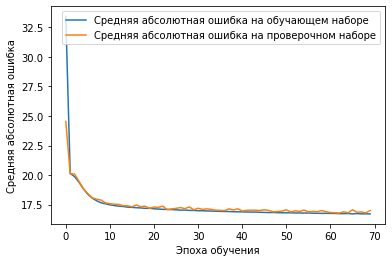

In [71]:
# Обучаем модель полученными данными
model = Sequential()
model.add(BatchNormalization(input_shape=(xTrain01.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(1000, activation='tanh'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(lr=1e-5), loss='mse', metrics=['mae'])

history = model.fit(xTrain01, 
                    yTrain, 
                    epochs=70, 
                    batch_size=500,
                    validation_split=0.15, 
                    verbose=2)

plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [72]:
# Делаем предсказание и приводим его к начальному виду
pred = model.predict(xTrain01)
pred = pred.flatten()
# Среднее значение ошибки 
delta = pred - yTrain
absDelta = abs(delta)
print(sum(absDelta) / len(absDelta))

16.909483729960492


In [73]:
# Получение результатов для теста
pred = model.predict(xTest)
pred.flatten()
pred[3]

array([33.96067], dtype=float32)

In [74]:
# В качестве нормализации данных используем готовую библиотеку 
yScaler = StandardScaler()

# Скармливаем объекту двумерный вектор
yScaler.fit(yTrain.reshape(-1, 1))

# Нормализуем по нормальному распределению
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1))

print(yTrainScaled.shape)
print(yTrain[1])
print(yTrainScaled[1])

(303851, 1)
14.0
[-0.77223925]


In [35]:
print(min(yTrain), max(yTrain))
print(min(yTrainScaled), max(yTrainScaled))

0.026 2283.641
[-1.16799849] [63.50652087]


Epoch 1/200
173/173 - 1s - loss: 0.9002 - mae: 0.5685 - val_loss: 0.9142 - val_mae: 0.5487
Epoch 2/200
173/173 - 1s - loss: 0.8096 - mae: 0.5264 - val_loss: 0.8455 - val_mae: 0.5177
Epoch 3/200
173/173 - 1s - loss: 0.7836 - mae: 0.5130 - val_loss: 0.8223 - val_mae: 0.5082
Epoch 4/200
173/173 - 1s - loss: 0.7710 - mae: 0.5061 - val_loss: 0.8138 - val_mae: 0.5021
Epoch 5/200
173/173 - 1s - loss: 0.7624 - mae: 0.5011 - val_loss: 0.8073 - val_mae: 0.5031
Epoch 6/200
173/173 - 1s - loss: 0.7560 - mae: 0.4975 - val_loss: 0.8023 - val_mae: 0.5014
Epoch 7/200
173/173 - 1s - loss: 0.7511 - mae: 0.4950 - val_loss: 0.7985 - val_mae: 0.4931
Epoch 8/200
173/173 - 1s - loss: 0.7468 - mae: 0.4921 - val_loss: 0.7947 - val_mae: 0.4947
Epoch 9/200
173/173 - 1s - loss: 0.7432 - mae: 0.4906 - val_loss: 0.7917 - val_mae: 0.4940
Epoch 10/200
173/173 - 1s - loss: 0.7402 - mae: 0.4888 - val_loss: 0.7891 - val_mae: 0.4916
Epoch 11/200
173/173 - 1s - loss: 0.7373 - mae: 0.4868 - val_loss: 0.7866 - val_mae: 0.48

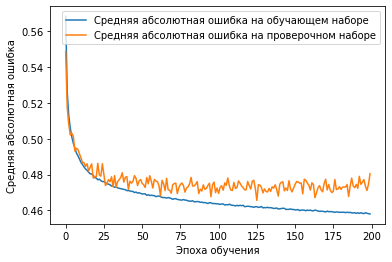

In [84]:
# Обучаем модель стандартизированными данными
modelS = Sequential()
modelS.add(BatchNormalization(input_shape=(xTrain01.shape[1],)))
modelS.add(Dense(128, activation='relu'))
modelS.add(Dense(1000, activation='tanh'))
modelS.add(Dense(100, activation='relu'))
modelS.add(Dense(1, activation='linear'))

modelS.compile(optimizer=Adam(lr=1e-5), loss='mse', metrics=['mae'])

history = modelS.fit(xTrain01, 
                    yTrainScaled, 
                    epochs=200, 
                    batch_size=1500,
                    validation_split=0.15, 
                    verbose=2)

plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [85]:
# Делаем предсказание и приводим его к начальному виду
pred = modelS.predict(xTrain01)
predUnscaled = yScaler.inverse_transform(pred).flatten()

# Среднее значение ошибки 
delta = predUnscaled - yTrain
absDelta = abs(delta)
print(sum(absDelta) / len(absDelta))

16.44152392375367


In [92]:
# Получение результатов для теста
pred = modelS.predict(xTest)
predUnscaled = yScaler.inverse_transform(pred).flatten()
predUnscaled[3]

32.784748

In [93]:
pred = predUnscaled*1000
#result = 
#result.head()

print(pred)

[42338.125 42545.684 71971.24  ... 52198.355 33639.79  24758.516]


In [63]:
pred.reshape(-1,1)

array([[40487.07 ],
       [37510.617],
       [57185.383],
       ...,
       [50428.54 ],
       [26704.502],
       [23455.713]], dtype=float32)

In [94]:
test['salary'] = pred
solution = test[['id','salary']]

In [95]:
solution.to_csv('/content/drive/MyDrive/Hakaton/solution.csv', sep=',', index=False)

## Оценка результатов





In [89]:
yy = model.predict(xTrain01) # Результат для всего тренировочного набора

In [90]:
n = 10
for i in range(n):
  print('Реальное значение - ',yTrain[i], " Предсказанное значение - ", yy[i][0], " Разница - ", abs(yTrain[i]-yy[i][0]))

Реальное значение -  37.5  Предсказанное значение -  41.287395  Разница -  3.787395477294922
Реальное значение -  14.0  Предсказанное значение -  30.118807  Разница -  16.118806838989258
Реальное значение -  24.6  Предсказанное значение -  31.679356  Разница -  7.079355621337889
Реальное значение -  16.075  Предсказанное значение -  37.569946  Разница -  21.4949462890625
Реальное значение -  22.08  Предсказанное значение -  45.400463  Разница -  23.32046310424805
Реальное значение -  31.14  Предсказанное значение -  30.82586  Разница -  0.3141409301757818
Реальное значение -  27.6  Предсказанное значение -  43.964947  Разница -  16.36494674682617
Реальное значение -  33.12  Предсказанное значение -  65.109146  Разница -  31.989146118164065
Реальное значение -  22.5  Предсказанное значение -  42.607952  Разница -  20.107952117919922
Реальное значение -  139.104  Предсказанное значение -  86.415504  Разница -  52.68849554443361


##Используем простые текстовые данные


In [10]:
# Выкачиваем данные по профессиям
def getXTrainTProf(values):
  xTrainTProf = []
  
  for val in values:
    currText = ""
    if (type(val) != float):
      currText += val
    
    
     # Проверяем, если есть данные о зарплате
    xTrainTProf.append(currText)
  
  xTrainTProf = np.array(xTrainTProf)
  
  return xTrainTProf

In [11]:
# Вытаскиваем професии для выборки
xTrainTProf = getXTrainTProf(fixed_df.position) 
print(xTrainTProf[:100]) # пример профессии 11го резюме

['Специалист' 'Лаборант' 'Специалист, администратор, бухгалтер, экономист'
 'Специалист' 'Инструктор по плаванию' 'учитель технологии'
 'контролер отк'
 'Юрист, Юриспруденция, ФССП, Федеральная Служба Судебных Приставов.'
 'Кондитер' 'Бурильщик ЭРБС' 'Оператор котельной'
 'Специалист по туристическим услугам' 'главный механик, механик'
 'Медицинская сестра' 'Инспектор' 'подсобный рабочий' 'ищу работу'
 'бухгалтер' 'Юрист' 'Менеджер, администратор, директор'
 'Руководитель транспортной службы' 'Санитарка' 'Лаборант'
 'Строительная сфера' 'Раскройщица натяжных потолков'
 'Графический дизайнер' 'Управляющий'
 'Специалист в области охраны труда и промышленной безопасности, гражданской обороны и пожарной безопасности'
 'Главный бухгалтер' 'инженер' 'Мастер маникюра' 'Аналитик' 'Монтажник'
 'Товаровед,старший продавец' 'Менеджер по обслуживанию клиентов'
 'HTML - верстальщик' 'Продавец продовольственных товаров' 'Кассир'
 'Машинист (кочегар) котельной' 'Электромонтер'
 'Учитель в начальных к

In [35]:
len(xTrainTProf)

303851

In [12]:
#################
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#################

maxWordsCount = 5000 #определяем макс.кол-во слов/индексов, учитываемое при обучении текстов

#для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=True)
#выше задаем параметры:
#(num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов0
#(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
#(lower=True) - приводим слова к нижнему регистру
#(split=' ') - разделяем слова по пробелу
#(char_level=False) - просим токенайзер не удалять однобуквенные слова

tokenizer.fit_on_texts(xTrainTProf) # "скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items())  #Вытаскиваем индексы слов для просмотра

In [13]:
#преобразовываем текст в последовательность индексов согласно частотному словарю
xTrainProfIndexes = tokenizer.texts_to_sequences(xTrainTProf) #обучающие тесты в индексы

## Создание обучающей и проверочной выборки

*Разбор данного раздела:* https://youtu.be/h8cOCvlYmN8?t=1451


In [14]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrainProf01 = tokenizer.sequences_to_matrix(xTrainProfIndexes) # Подаем xTrain в виде списка чтобы метод успешно сработал
print(xTrainProf01.shape)                                       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrainProf01[0][0:50])        

(303851, 5000)
[0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [39]:
n = 0
print(xTrainTProf[n])       # Профессия
print(xTrainProfIndexes[n]) # Профессия через индексы

Специалист
[10, 14, 3, 23, 4, 5, 11, 4, 10, 7]


In [40]:
xTrainProf01.shape

(303851, 1000)

In [32]:
yTrain.shape

(303851,)

##Обучаем нейронку на простых текстовых данных

In [ ]:
# Предсказываем по предыдущей работе и желаемой
modelTProf = Sequential()
modelTProf.add(Dense(20, activation='relu', input_dim=(xTrainProf01.shape[1]) ) )
modelTProf.add(Dense(500, activation='relu'))
modelTProf.add(Dense(1, activation='linear'))

modelTProf.compile(optimizer=Adagrad(lr=1e-3), loss='mse', metrics=['mae'])

history = modelTProf.fit(xTrainProf01[:50000], 
                    yTrain[:50000], 
                    batch_size=20,
                    epochs=50, 
                    #validation_split=0.1, 
                    validation_data=(xTrainProf01[50000:], yTrain[50000:]),
                    verbose=1, shuffle=True)

plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

Epoch 1/50
2481/2500 [============================>.] - ETA: 0s - loss: 1969.6424 - mae: 28.1387

In [ ]:
del xTrainProf01 # Удаляем переменную, иначе дальше может вылететь из-за нехватки памяти

In [44]:
modelTProf.save('/content/drive/MyDrive/Hakaton/simple_text.h5')

##Загружаем сложные текстовые данные

*Разбор данного раздела:* https://youtu.be/h8cOCvlYmN8?t=1566

In [ ]:
# Выкачиваем данные по резюме
def getXTrainTRez(values):
  xTrainTRez = []
  
  for val in values:
    currText = ""
    if (type(val[6]) != float):
      currText += val[6]
    
    if (getParameterSalary(val[1]) != -1):
      xTrainTRez.append(currText)
  
  xTrainTRez = np.array(xTrainTRez)
  
  return xTrainTRez

In [ ]:
# Вытаскиваем резюме для выборки
xTrainTRez = getXTrainTRez(fixed_df.values)

In [ ]:
print(xTrainTRez[10]) # Пример профессии 11го резюме

Опыт работы 27 лет 4 месяца  Программист 2 000 EUR Информационные технологии, интернет, телеком Программирование, Разработка Системная интеграция Занятость: полная занятость График работы: полный день Опыт работы 27 лет 4 месяца Январь 2008 — по настоящее время 11 лет 4 месяца Консалтинг КАС Главный аналитик Программирование на разных версиях RPG для AS/400 (iSeries). Модификация и доработка существующего кода, расширения функциональности системы. Разработка новых модулей и подсистем. Постановка задач, управление проектами. Январь 1993 — Январь  2008 15 лет 1 месяц Артекс, крупнейший дилер БМВ в Москве Директор по ИТ Доработка существующей системы управления дилерским предприятием (AS/400, iSeries). Все версии RPG (RPG36, RPG400, ILE RPG). Работа с DB2. Расширение функциональности системы, изменение системы, согласно действующему законодательству РФ. Руководство проектами, координация действий различных подразделений компании и сторонних организаций. Бюджетирование. Исследование бизнес

In [ ]:
#################
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#################

maxWordsCount = 5000 #определяем макс.кол-во слов/индексов, учитываемое при обучении текстов

#для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
#выше задаем параметры:
#(num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
#(lower=True) - приводим слова к нижнему регистру
#(split=' ') - разделяем слова по пробелу
#(char_level=False) - просим токенайзер не удалять однобуквенные слова

tokenizer.fit_on_texts(xTrainTRez)         # "скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра

In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
xTrainRezIndexes = tokenizer.texts_to_sequences(xTrainTRez) # Обучающие тесты в индексы

## Создание обучающей и проверочной выборки

Функции для формирования выборки по отрезкам текста с заданным шагом

Подготовка данных

In [ ]:
xTrainRez01 = tokenizer.sequences_to_matrix(xTrainRezIndexes) # Подаем xTrain в виде списка чтобы метод успешно сработал
print(xTrainRez01.shape)                                      # Размер обучающей выборки, сформированной по Bag of Words
print(xTrainRez01[0][0:100])    

(62967, 5000)
[0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 1. 0.]


In [ ]:
print(xTrainRez01.shape) # Размер выборки самых частых слов
print(xTrainRez01[555]) # Пример из отформатированной выборки

(62967, 5000)
[0. 0. 1. ... 0. 0. 0.]


##Обучаем нейронку на сложных текстовых данных




Epoch 1/20
2500/2500 [==============================] - 5s 2ms/step - loss: 15660.3145 - mae: 27.4569 - val_loss: 1513.4458 - val_mae: 24.8467
Epoch 2/20
2500/2500 [==============================] - 5s 2ms/step - loss: 14903.1260 - mae: 23.8727 - val_loss: 1540.6873 - val_mae: 25.7508
Epoch 3/20
2500/2500 [==============================] - 5s 2ms/step - loss: 14090.9912 - mae: 22.9985 - val_loss: 1428.7754 - val_mae: 23.5003
Epoch 4/20
2500/2500 [==============================] - 6s 2ms/step - loss: 13188.4990 - mae: 21.2798 - val_loss: 1505.1117 - val_mae: 23.7810
Epoch 5/20
2500/2500 [==============================] - 5s 2ms/step - loss: 11952.0039 - mae: 19.8930 - val_loss: 1428.9722 - val_mae: 23.5358
Epoch 6/20
2500/2500 [==============================] - 5s 2ms/step - loss: 10167.0332 - mae: 18.7258 - val_loss: 2941.7305 - val_mae: 31.4668
Epoch 7/20
2500/2500 [==============================] - 5s 2ms/step - loss: 9631.6514 - mae: 18.8640 - val_loss: 1475.1525 - val_mae: 23.7413


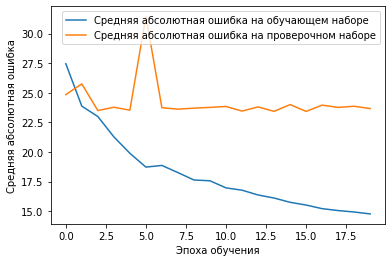

In [ ]:
# здесь в параметрах maxWordCount = 2000
modelTRez = Sequential()
modelTRez.add(Dense(20, activation='relu',input_dim=(xTrainRez01.shape[1])))
modelTRez.add(Dense(500, activation='relu'))
modelTRez.add(Dropout(0.3))
modelTRez.add(Dense(1, activation='linear'))
 
modelTRez.compile(optimizer=Adam(lr=1e-3), loss='mse', metrics=['mae'])
 
history = modelTRez.fit(xTrainRez01[:50000], 
                    yTrain[:50000], 
                    batch_size=20,
                    epochs=20, 
                    validation_data=(xTrainRez01[50000:], yTrain[50000:]),
                    verbose=1, shuffle=True)
 
plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

##Составная нейронка



In [15]:
input1 = Input((xTrain01.shape[1],))
input2 = Input((xTrainProf01.shape[1],))
#input3 = Input((xTrainRez01.shape[1],))

x1 = BatchNormalization()(input1) # Создаем ветку х1
x1 = Dropout(0.5)(x1)
x1 = Dense(10, activation="relu")(x1)
x1 = Dense(1000, activation="relu")(x1)
x1 = Dense(100, activation = "relu")(x1)

x2 = BatchNormalization()(input2) # Создаем ветку х2
x2 = Dense(25, activation="relu")(input2)
x2 = Dense(8, activation="tanh")(x2)
x2 = Dense(5, activation = "elu")(x2)

#x3 = BatchNormalization()(input3) # Создаем ветку х3
#x3 = Dense(1000, activation="tanh")(input3)
#x3 = Dense(20, activation = "elu")(x3)
#x3 = Dense(5, activation = "elu")(x3)

x = concatenate([x1, x2]) # Объединяем все три ветки

x = Dense(15, activation='linear')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='relu')(x) # Финальный нейрон, делает регрессию

model = Model((input1, input2), x) # В Model загружаем стартовые и последнюю точки 

model.compile(optimizer=Adam(lr=1e-3), loss='mse', metrics=['mae'])

history = model.fit([xTrain01[:50000], xTrainProf01[:50000]], 
                    yTrain[:50000], 
                    epochs= 80, 
                    validation_data=([xTrain01[50000:], xTrainProf01[50000:]], 
                    yTrain[50000:]), 
                    verbose=1, shuffle=True)

Epoch 1/80
1563/1563 [==============================] - 30s 17ms/step - loss: 1500.4421 - mae: 22.3871 - val_loss: 940.3130 - val_mae: 17.3244
Epoch 2/80
1563/1563 [==============================] - 24s 16ms/step - loss: 1191.5761 - mae: 19.7223 - val_loss: 981.5781 - val_mae: 16.7958
Epoch 3/80
1563/1563 [==============================] - 25s 16ms/step - loss: 1169.3249 - mae: 19.7083 - val_loss: 959.8932 - val_mae: 16.5889
Epoch 4/80
1563/1563 [==============================] - 26s 16ms/step - loss: 1142.7996 - mae: 19.2777 - val_loss: 942.5017 - val_mae: 16.7426
Epoch 5/80
1563/1563 [==============================] - 25s 16ms/step - loss: 1344.0696 - mae: 19.5519 - val_loss: 920.5020 - val_mae: 16.9710
Epoch 6/80
1563/1563 [==============================] - 25s 16ms/step - loss: 1116.4081 - mae: 19.0428 - val_loss: 985.9606 - val_mae: 16.3841
Epoch 7/80
1563/1563 [==============================] - 24s 15ms/step - loss: 1215.6286 - mae: 19.2362 - val_loss: 986.0775 - val_mae: 16.3500

In [1]:
plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

NameError: ignored

In [47]:
model.save('/content/drive/MyDrive/Hakaton/complex.h5')

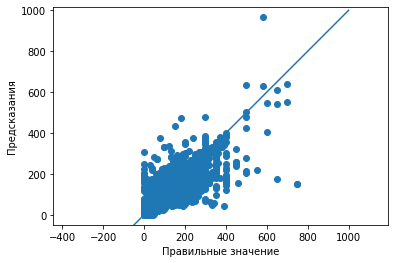

In [ ]:
yy = yTrain[50000:] # Зарплата
pred = model.predict([xTrain01[50000:], xTrainRez01[50000:]]) # Предсказанная зарплата
plt.scatter(yy, pred)
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot([-1000, 1000], [-1000, 1000])
plt.show()

In [64]:
del xTrainRez01, xTrainRezIndexes # Удаляем некоторые переменные, иначе дальше может вылететь из-за нехватки памяти

NameError: ignored

In [48]:
XTest = getXTrainTProf(test.position) 

In [50]:
#################
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#################

maxWordsCount = 1000 #определяем макс.кол-во слов/индексов, учитываемое при обучении текстов

#для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=True)
#выше задаем параметры:
#(num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов0
#(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
#(lower=True) - приводим слова к нижнему регистру
#(split=' ') - разделяем слова по пробелу
#(char_level=False) - просим токенайзер не удалять однобуквенные слова

tokenizer.fit_on_texts(XTest) # "скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items())  #Вытаскиваем индексы слов для просмотра

In [51]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
XTestIndexes = tokenizer.texts_to_sequences(XTest) # Обучающие тесты в индексы

In [52]:
XTest01 = tokenizer.sequences_to_matrix(XTestIndexes) # Подаем xTrain в виде списка чтобы метод успешно сработал
print(XTest01.shape)                                      # Размер обучающей выборки, сформированной по Bag of Words
print(XTest01[0][0:100])

(131259, 1000)
[0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [56]:
pred = model.predict([xTest, XTest01])

In [59]:
pred=pred*1000

In [61]:
pred.reshape(-1,1)

array([[42021.547],
       [44199.656],
       [57172.805],
       ...,
       [49404.832],
       [35103.473],
       [26353.844]], dtype=float32)

In [62]:
test['salary'] = pred
solution = test[['id','salary']]

In [63]:
solution.to_csv('/content/drive/MyDrive/Hakaton/solution1.csv', sep=',', index=False)